# Visualization and statistical analysis

Save the results as a 'destination folder/*-stats.csv' file

Define the result folder

In [5]:
import yaml
from pathlib import Path
from ipyfilechooser import FileChooser
srcdir, dstdir = '', ''
if Path("config.yml").exists():
    with open("config.yml", "r") as file:    
        config = yaml.safe_load(file)
        if 'source' in config.keys():
            srcdir = Path(config["source"])        
        if 'destination' in config.keys():
            dstdir = Path(config["destination"]) 

fc = FileChooser(dstdir, select_desc='Destination')
display(fc)

FileChooser(path='/home/jeromeb/work/code/octopus/results', filename='', title='', show_hidden=False, select_d…

In [10]:
import pandas as pd
dstdir = Path(fc.selected) if fc.selected is not None else Path(dstdir)
filelistname = dstdir / 'filelist.csv'
filelist = pd.read_csv(filelistname)
filelist

,folder,name,channel1,channel2,channel3,channel4
0,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnal...,vglut_B4_546,ppp1_B1_647,Th_B3_488,Nuclei
1,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnal...,tbh_B4_546,LGC007_B3_647,vacht_B2_488,Nuclei
2,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,2023_20Dec_2aBatch2_12Dec_F1_Stitched_Cropped_...,LGC041_B2_546,LGC046_B2_647,Th_B3_488,Nuclei
3,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAna...,LGC009_B1_647,vglut_B4_546,Th_B3_488,Nuclei


In [18]:
from itertools import chain, combinations
from functools import partial
import numpy as np
import tifffile
import napari

def get_files(dstdir, row, key=None):
    if key == 'ims':
        return Path(row['folder']) / row['name']
    elif key == 'regions':
        return Path(dstdir / str(row["name"]).replace('.ims','-regions.json'))
    elif key == 'labels':
        return Path(dstdir / str(row['name']).replace('.ims','-labels.tif'))
    elif key == 'measurements':
        return Path(dstdir / str(row['name']).replace('.ims','-measurements.csv'))
    elif key == 'stats':
        return Path(dstdir / str(row['name']).replace('.ims','-stats.csv'))
    else:
        return {
            'ims': get_files(dstdir, row, 'ims'),
            'regions': get_files(dstdir, row, 'regions'),
            'labels': get_files(dstdir, row, 'labels'),
            'measurements':  get_files(dstdir, row, 'measurements')
        }
    
def get_measurement_channels(df,prefix='c'):
    """List the channels name from the measurement data"""
    return [f'{prefix}{k}' for k in range(10) if f'{prefix}{k}' in df.columns]
    
def create_heatmaps(labels, df):    
    channel_columns = [f'c{k}' for k in range(10) if f'c{k}' in df.columns]

    heatmaps = np.zeros([len(channel_columns), *labels.shape])
    for row in df.iloc:
        for k, c in enumerate(channel_columns):
                heatmaps[k][labels == row['label']] = row[c]  
    return heatmaps

def madstd(x):
    """Median std"""
    return 1.48 * np.median(np.abs(x-np.median(x)))

def powerset(iterable):
    """Compute the powerset of iterable"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def encode(row, channels, thresholds, encoder):
    """compute a code from the channels columns and the tresholds"""
    t = tuple([c for c in channels if row[c] > thresholds[c]])
    return encoder[t]

def encode_channels(df, channels, thresholds):
    """Encode the channel in the data frame based on intensity (in place)
    
    Parameters
    ----------
    df : pd.DataFrame
    channels : List[str]
        list of channel names
    thresholds: List[float]
        list of threshold values
    
    Returns
    -------
    
    """
    pset = [x for x in powerset(channels)]    
    encoder = {x:k for k,x in enumerate(pset)}    
    decoder = {k:x for k,x in enumerate(pset)}
    decoder[0] = 'none'
    #df.drop('code id', inplace=True)
    #df.drop('code str', inplace=True)
    df['code id'] = df.apply(partial(encode, channels=channels, encoder=encoder, thresholds=thresholds), axis=1)
    decode_str = {a:b for a,b in enumerate([''.join([str(e) for e in k]) for k in encoder.keys()])}
    df['code str'] = [decode_str[k] for k in df['code id']]
    return encoder, decoder

def create_codemaps(labels, df, decoder):
    """Create a map of the binary codes
    Note add 1 to the code so that it is not set to background
    """
    stack = np.zeros(labels.shape, dtype=np.uint8)
    for row in df.iloc:
        stack[labels == row['label']] = row['code id'] + 1        
    features = pd.DataFrame({'code':[ 'background', *[''.join(decoder[k]) for k in decoder ]]})
    return stack, features


In [12]:
import ipywidgets as widgets
w = widgets.Dropdown(
    options=[(x,k) for k,x in enumerate(filelist['name'])],
    value=1,
    description='Image:'
)
display(w)

Dropdown(description='Image:', index=1, options=(('2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnalysis.ims', 0)…

Load the image

In [13]:
from imaris_ims_file_reader.ims import ims
row = filelist.iloc[w.value]
resolution_level = 1 # need to be the same than the one used for processing
img = ims(get_files(dstdir, row, 'ims'), ResolutionLevelLock=resolution_level)

Opening readonly file: /media/cephfs/acourtney/HCR_Octopus_Jerome/Febuary2024/test_15024/2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnalysis.ims 



Add codes to the dataframe

In [21]:
labels = tifffile.imread(get_files(dstdir, row, 'labels'))

df = pd.read_csv(get_files(dstdir, row, 'measurements'), index_col=0)
df = pd.DataFrame(df.to_records())

channels = get_measurement_channels(df,'ch')

# compute the thresholds
thresholds = {c:df[c].median() + 0.5 * madstd(df[c]) for c in channels}            

for k,c in enumerate(channels):
    df[f'z{k}'] = (df[c] - df[c].median()) / madstd(df[c])

encoder, decoder = encode_channels(df, channels, thresholds)
df = df[ df['code id'] !=0 ] 


In [50]:
#def map_channels_names(channels):

#map_channels_names()
get_measurement_channels(row.to_frame().T,'channel')
#row[f'channel{k+1}']
names = {f'c{k}':row[f'channel{k+1}'] for k in range(4)}
channels = ['c0','c1','c3']
[names[c] for c in channels]



['tbh_B4_546', 'LGC007_B3_647', 'Nuclei']

Compute the map

In [22]:
codemaps, features = create_codemaps(labels, df, decoder)

Visualize the result
- toggle the label layer to visualize the codes
- on the codemaps layer, tick the 'show selected' option and run through the labels to display the cells code by code

In [18]:
v = napari.view_image(img, channel_axis=0)
v.add_labels(labels)
v.add_labels(codemaps, features=features)

<Labels layer 'codemaps' at 0x7f3d30bf22a0>

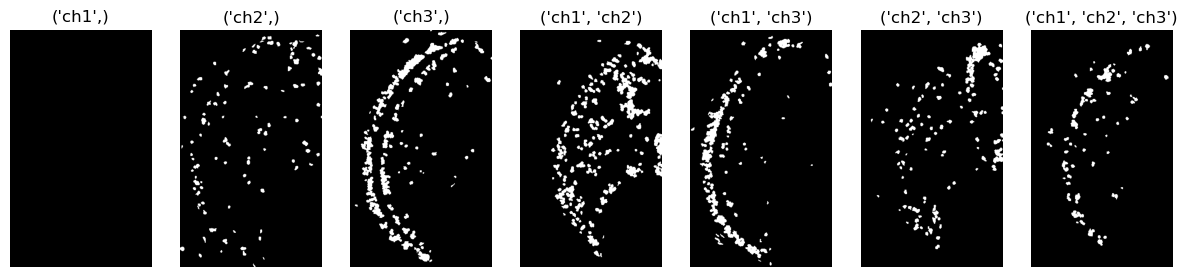

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,7,figsize=(15,5))
for k in range(1,8):    
    ax[k-1].imshow(np.amax(codemaps[:,::4,::4]==k,0), cmap='gray')
    ax[k-1].set(title=f'{decoder[k]}')
    ax[k-1].set_axis_off()

In [11]:
tbl = pd.pivot_table(df.groupby(['roi','code str'])['label'].agg('count').to_frame(), values='label', index='roi',columns='code str').fillna(0)
tbl

code str,ch1,ch1ch2,ch1ch2ch3,ch1ch3,ch2,ch2ch3,ch3
roi,,,,,,,
0.0,55.0,68.0,90.0,77.0,86.0,30.0,92.0
1.0,26.0,132.0,15.0,2.0,149.0,3.0,0.0
2.0,9.0,17.0,58.0,38.0,47.0,49.0,92.0
3.0,23.0,6.0,35.0,44.0,13.0,11.0,129.0


In [12]:
relative = 100*tbl.div(tbl.sum(axis=1), axis=0)
relative.to_csv(get_files(dstdir, row, 'stats'))
relative


code str,ch1,ch1ch2,ch1ch2ch3,ch1ch3,ch2,ch2ch3,ch3
roi,,,,,,,
0.0,11.044177,13.654618,18.072289,15.461847,17.269076,6.024096,18.473896
1.0,7.951070,40.366972,4.587156,0.611621,45.565749,0.917431,0.000000
2.0,2.903226,5.483871,18.709677,12.258065,15.161290,15.806452,29.677419
3.0,8.812261,2.298851,13.409962,16.858238,4.980843,4.214559,49.425287


Text(0.5, 1.0, '2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnalysis.ims')

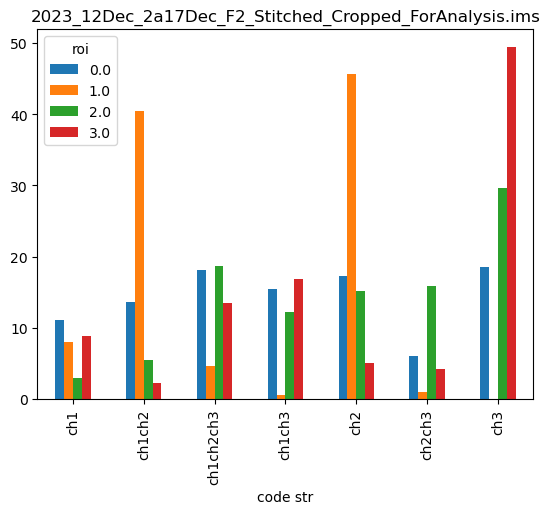

In [17]:
relative.T.plot(kind='bar');
plt.title(row['name'])